In [1]:
import os
os.chdir('..')

# IMPORTS

In [2]:
from matplotlib import rcParams, cycler

CUDA_VISIBLE_DEVICES = ""
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import random
import json
import copy
import torch
import sklearn
from torch import nn
import os
from src.utils.pool_metrics import get_PCC, get_qc_euclidean, get_batches_euclidean, get_euclidean
from scipy.spatial.distance import cdist, pdist

from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.decomposition import PCA
from umap import UMAP

from src.utils.batch_effect_removal import get_berm  # , remove_batch_effect
from src.dl.models.pytorch.aedann import Encoder2, Decoder2, Classifier, Classifier2, Classifier3, DispAct, MeanAct
from src.utils.utils import scale_data, get_unique_labels # , scale_data_per_batch
from src.dl.models.pytorch.utils.utils import to_categorical
from src.dl.models.pytorch.utils.plotting import confidence_ellipse
from src.dl.models.pytorch.utils.stochastic import GaussianSample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


import warnings
from sklearn.preprocessing import OneHotEncoder
from tabulate import tabulate

# import matplotlib
# matplotlib.use('Agg')
# from itertools import cycle
# from sklearn.cross_decomposition import CCA
# from src.utils.pool_metrics import log_pool_metrics
# from src.dl.models.pytorch.aedann import ReverseLayerF
#from src.dl.models.pytorch.utils.loggings import TensorboardLoggingAE, log_input_ordination, \
#    log_confusion_matrix, log_plots
# from src.dl.models.pytorch.utils.dataset import get_loaders
# from datetime import datetime
# from src.dl.models.pytorch.utils.utils import log_traces, get_best_loss_from_tb, get_best_acc_from_tb, get_best_values, add_to_logger, get_empty_dicts, get_empty_traces, get_optimizer

warnings.filterwarnings("ignore")

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

strategy = 'CU_DEM-AD'
# csv_name = 'unique_genes.csv'
# bad_batches = ''
# remove_zeros = 0
log_stuff = False
best_correction = False
n_meta = 2
train_models = True
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])
args.csv_file = 'unique_genes.csv'
args.remove_zeros = 0
args.bad_batches = ''
args.log1p = 1
args.zinb = 0
args.groupkfold = 1


/home/simonp/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/simonp/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/simonp/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The '

In [3]:
from skopt.space import Real, Integer, Categorical
from sklearn.ensemble import RandomForestClassifier
rfc_space = [
    # Integer(100, 20000, 'uniform', name='features_cutoff'),
    # Real(0, 1, 'uniform', name='threshold'),
    Integer(1, 100, 'uniform', name="max_features"),
    Integer(2, 10, 'uniform', name="min_samples_split"),
    Integer(1, 10, 'uniform', name="min_samples_leaf"),
    Integer(1, 1000, 'uniform', name="n_estimators"),
    Categorical(['gini', 'entropy'], name="criterion"),
    Categorical([True, False], name="oob_score"),
    Categorical(['balanced'], name="class_weight"),
]
linsvc_space = [
    # Integer(1, 20000, 'uniform', name='features_cutoff'),
    # Real(0, 1, 'uniform', name='threshold'),
    Real(1e-4, 1, 'log-uniform', name='tol'),
    Integer(1, 1000, 'uniform', name='max_iter'),
    Categorical(['l2'], name='penalty'),
    Real(1e-3, 10000, 'uniform', name='C'),
    Categorical(['balanced'], name='class_weight'),

]
logreg_space = [
    # Integer(1, 20000, 'uniform', name='features_cutoff'),
    # Real(0, 1, 'uniform', name='threshold'),
    Integer(1, 20000, 'uniform', name='max_iter'),
    Real(1e-3, 20000, 'uniform', name='C'),
    Categorical(['saga'], name='solver'),
    Categorical(['l1', 'l2'], name='penalty'),
    Categorical([True, False], name='fit_intercept'),
    Categorical(['balanced'], name='class_weight'),
]


In [4]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
def pyGPCA(data, group, name, metrics):
    gPCA = importr('gPCA')

    newdata = robjects.r.matrix(robjects.FloatVector(np.array(data['inputs'][group]).reshape(-1)), nrow=data['inputs'][group].shape[0])
    new_batches = robjects.r.matrix(robjects.IntVector(data['batches'][group]), nrow=data['inputs'][group].shape[0])

    results = gPCA.gPCA_batchdetect(newdata, new_batches)
    # print(results)
    # with localconverter(robjects.default_converter + pandas2ri.converter):
    #     results = np.array(robjects.conversion.rpy2py(results))
    # print(results)
    with localconverter(robjects.default_converter + pandas2ri.converter):
        results = { key : np.array(robjects.conversion.rpy2py(results.rx2(key))) for key in results.names }
        # metrics['raw']['delta'] = metrics['raw']['delta']))

    if 'pool' in name:
        delta_name = 'delta_pool'
        name = name.split('_')[1]
    else:
        delta_name = 'delta'
    if name not in metrics:
        metrics[name] = {}
        # print(results)
    metrics[name][delta_name] = results['delta'][0]
    # metrics[name]['delta.pval'] = results[1]
    return metrics, results

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()
standard_minmax_scaler = Pipeline([('standard', StandardScaler()), ('minmax', MinMaxScaler())])
robust_minmax_scaler = Pipeline([('robust', RobustScaler()), ('minmax', MinMaxScaler())])


In [6]:
from src.dl.models.pytorch.utils.loggings import log_LDA, log_ORD
from src.utils.data_getters import get_alzheimer

In [7]:
from src.utils.pool_metrics import log_pool_metrics
from src.dl.models.pytorch.utils.loggings import get_metrics, log_metrics, batch_f1_score
# from src import log_metrics
# log_metrics(logger, lists, values, model, unique_labels, unique_batches, epoch, mlops, metrics, n_meta_emb=0, device='cuda')

In [8]:

def use_pycombat(berm, data):
    df = pd.concat((
        data['inputs']['train'].copy(),  data['inputs']['valid'].copy(), data['inputs']['test'].copy(), 
        data['inputs']['train_pool'].copy(),  data['inputs']['valid_pool'].copy(), data['inputs']['test_pool'].copy(), 
    ))
    all_batches = np.concatenate((
        data['batches']['train'], data['batches']['valid'], data['batches']['test'],
        data['batches']['train_pool'], data['batches']['valid_pool'], data['batches']['test_pool'],
        
    ))
    # assert np.sum(all_batches != np.concatenate((data['batches']['train'], data['batches']['valid'], data['batches']['test']))) == 0
    tmp = berm(df.T, all_batches).T
    tmp = np.nan_to_num(tmp, 0)
    previous_len = 0
    for g in ['train', 'valid', 'test', 'train_pool', 'valid_pool', 'test_pool']:
        # print(g, previous_len, data['inputs'][g].shape[0])
        data['inputs'][g] = pd.DataFrame(
            tmp[previous_len:previous_len + data['inputs'][g].shape[0]],
            index=data['inputs'][g].index)
        previous_len += data['inputs'][g].shape[0]
        # print(g, previous_len, data['inputs'][g].shape[0])
    data['inputs']['all'] = pd.concat((
        data['inputs']['train'], data['inputs']['valid'], data['inputs']['test'],
        # data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
    ), 0)
    data['inputs']['all_pool'] = pd.concat((
        data['inputs']['train_pool'], data['inputs']['valid_pool'], data['inputs']['test_pool'],
    ), 0)

    return data

def remove_batch_effect(berm, data):
    """
    All dataframes have a shape of N samples (rows) x M features (columns)

    Args:
        berm: Batch effect removal method
        all_data: Pandas dataframe containing all data (train, valid and test data)
        data: list of Pandas dataframe containing the training data. Used only to get
        valid_data: Pandas dataframe containing the validation data
        test_data: Pandas dataframe containing the test data
        all_batches: A list containing the batch ids corresponding to all_data

    Returns:
        Returns:
        A dictionary of pandas datasets corrected for batch effect with keys:
            'all': Pandas dataframe containing all data (train, valid and test data)
            'train': Pandas dataframe containing the training data
            'valid': Pandas dataframe containing the validation data
            'test: Pandas dataframe containing the test data

    """
    if berm is not None:  # Look if has 20 before and after
        df = pd.concat((
            data['inputs']['train'].copy(),  data['inputs']['valid'].copy(), data['inputs']['test'].copy(), 
            data['inputs']['train_pool'].copy(),  data['inputs']['valid_pool'].copy(), data['inputs']['test_pool'].copy(), 
        ))
        all_batches = np.concatenate((
            data['batches']['train'], data['batches']['valid'], data['batches']['test'],
            data['batches']['train_pool'], data['batches']['valid_pool'], data['batches']['test_pool'],

        ))
        # assert np.sum(all_batches != np.concatenate((data['batches']['train'], data['batches']['valid'], data['batches']['test']))) == 0
        tmp = berm(df, all_batches)
        inputs_len = data['inputs']['train'].shape[0] + data['inputs']['train'].shape[0] + data['inputs']['valid'].shape[0] + \
                        data['inputs']['valid'].shape[0] + data['inputs']['test'].shape[0] + data['inputs']['test'].shape[0]
        previous_len = 0
        for g in ['train', 'valid', 'test', 'train_pool', 'valid_pool', 'test_pool']:
            if 'all' in g:
                continue
            print(g, previous_len)
            data['inputs'][g] = pd.DataFrame(
                tmp[previous_len:previous_len + data['inputs'][g].shape[0]],
                index=data['inputs'][g].index)
            previous_len += data['inputs'][g].shape[0]
        data['inputs']['all'] = pd.concat((
            data['inputs']['train'], data['inputs']['valid'], data['inputs']['test'],
            # data[key]['train_pool'], data[key]['valid_pool'], data[key]['test_pool'],
        ), 0)
        data['inputs']['all_pool'] = pd.concat((
            data['inputs']['train_pool'], data['inputs']['valid_pool'], data['inputs']['test_pool'],
        ), 0)

    return data

def remove_batch_effect_with_classes(berm, data, classes):
    """
    All dataframes have a shape of N samples (rows) x M features (columns)

    Args:
        berm: Batch effect removal method
        all_data: Pandas dataframe containing all data (train, valid and test data)
        data: list of Pandas dataframe containing the training data. Used only to get
        valid_data: Pandas dataframe containing the validation data
        test_data: Pandas dataframe containing the test data
        all_batches: A list containing the batch ids corresponding to all_data

    Returns:
        Returns:
        A dictionary of pandas datasets corrected for batch effect with keys:
            'all': Pandas dataframe containing all data (train, valid and test data)
            'train': Pandas dataframe containing the training data
            'valid': Pandas dataframe containing the validation data
            'test: Pandas dataframe containing the test data

    """
    if berm is not None:  # Look if has 20 before and after
        df = pd.concat((
            data['inputs']['train'].copy(), data['inputs']['valid'].copy(), data['inputs']['test'].copy()
        ))
        all_batches = np.concatenate((
            data['batches']['train'], data['batches']['valid'], data['batches']['test']
        ))
        # assert np.sum(all_batches != np.concatenate((data['batches']['train'], data['batches']['valid'], data['batches']['test']))) == 0
        tmp = berm(df, all_batches, classes)
        inputs_len = data['inputs']['train'].shape[0] + data['inputs']['valid'].shape[0] + data['inputs']['test'].shape[0]
        previous_len = 0
        for g in list(data['inputs'].keys()):
            if 'all' in g:
                continue
            print(g, previous_len)
            data['inputs'][g] = pd.DataFrame(
                tmp[previous_len:previous_len + data['inputs'][g].shape[0]],
                index=data['inputs'][g].index)
            previous_len += data['inputs'][g].shape[0]
        try:
            data['inputs']['all'] = pd.DataFrame(tmp, index=df.index, columns=df.columns)
        except:
            data['inputs']['all'] = pd.DataFrame(tmp, index=df.index)

    return data



In [10]:
def save_confusion_matrix(fig, name, acc, mcc, group):
    # sns_plot = sns.heatmap(df, annot=True, square=True, cmap="YlGnBu",
    #                        annot_kws={"size": 35 / np.sqrt(len(df))})
    # fig = sns_plot.get_figure()
    dirs = '/'.join(name.split('/')[:-1])
    name = name.split('/')[-1]
    plt.title(f'Confusion Matrix (acc={np.round(np.mean(acc), 2)} +- {np.round(np.std(acc), 2)}, mcc={np.round(np.mean(mcc), 2)} +- {np.round(np.std(mcc), 2)})')
    os.makedirs(f'{dirs}/', exist_ok=True)
    stuck = True
    while stuck:
        try:
            fig.savefig(f"{dirs}/cm_{name}_{group}.png")
            stuck = False
        except:
            print('stuck...')
    plt.close()



In [12]:
from skopt import gp_minimize
from src.ml.train.sklearn_train_nocv import count_labels, get_confusion_matrix, save_roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.multiclass import OneVsRestClassifier
# from sklearn import metrics
from sklearn.metrics import roc_auc_score
from src.utils.utils import plot_confusion_matrix

class Train:
    def __init__(self, name, model, data, hparams_names, log_path, args, logger, ovr, model_name='RF', binary=True, mlops='None'):
        self.best_roc_score = -1
        self.ovr = ovr
        self.binary = binary
        self.args = args
        self.log_path = log_path
        self.model = model
        self.model_name = model_name
        self.data = data
        self.logger = logger
        self.hparams_names = hparams_names
        # self.train_indices, self.test_indices, _ = split_train_test(self.labels)
        # self.n_splits = args.n_splits
        # self.n_repeats = args.n_repeats
        # self.jackknife = args.jackknife
        self.best_scores_train = -1
        self.best_scores_valid = -1
        self.best_mccs_train = -1
        self.best_mccs_valid = -1
        self.scores_train = None
        self.scores_valid = None
        self.mccs_train = None
        self.mccs_valid = None
        self.y_preds = np.array([])
        self.y_valids = np.array([])
        self.iter = 0
        self.model = model
        self.name = name
        self.mlops = mlops
        self.best_params_dict = {}
        self.best_params_dict_values = {}

    def train(self, h_params, groupkfold=1):
        self.iter += 1
        features_cutoff = None
        param_grid = {}
        for name, param in zip(self.hparams_names, h_params):
            if name == 'features_cutoff':
                features_cutoff = param
            elif name == 'threshold':
                threshold = param
            else:
                param_grid[name] = param
        scores_valid = []
        scores_train = []
        scores_test = []
        y_preds_train = []
        y_preds_valid = []
        y_preds_test = []

        train_classes = []
        valid_classes = []
        test_classes = []
        
        mccs_train = []
        mccs_valid = []
        mccs_test = []
        all_data = data['inputs']['all']
        all_meta = data['meta']['all']
        all_labels = data['labels']['all']
        # all_names = data['names']['all']
        all_batches = data['batches']['all']
        all_cats = data['cats']['all']
        print(f'Iteration: {self.iter}')
        for h in range(5):
            if groupkfold:
                skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=h)
                train_nums = np.arange(0, len(all_labels))
                # Remove samples from unwanted batches
                train_inds, valid_inds = skf.split(train_nums, all_labels, all_batches).__next__()
            else:
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
                train_nums = np.arange(0, len(all_labels))
                train_inds, valid_inds = skf.split(train_nums, all_labels).__next__()
            train_data, valid_data = all_data.iloc[train_inds], all_data.iloc[valid_inds]
            train_meta, valid_meta = all_meta.iloc[train_inds], all_meta.iloc[valid_inds]
            train_labels, valid_labels = all_labels[train_inds], all_labels[valid_inds]
            # train_names, valid_names = all_names[train_inds], all_names[valid_inds]
            train_batches, valid_batches = all_batches[train_inds], all_batches[valid_inds]
            train_cats, valid_cats = all_cats[train_inds], all_cats[valid_inds]

            if groupkfold:
                skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=h)
                train_nums = np.arange(0, len(train_labels))
                # Remove samples from unwanted batches
                train_inds, test_inds = skf.split(train_nums, train_labels, train_batches).__next__()
            else:
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)
                train_nums = np.arange(0, len(train_labels))
                train_inds, test_inds = skf.split(train_nums, train_labels).__next__()
            train_data, test_data = train_data.iloc[train_inds], train_data.iloc[test_inds]
            train_meta, test_meta = train_meta.iloc[train_inds], train_meta.iloc[test_inds]
            train_labels, test_labels = train_labels[train_inds], train_labels[test_inds]
            # train_names, test_names = train_names[train_inds], train_names[test_inds]
            train_batches, test_batches = train_batches[train_inds], train_batches[test_inds]
            train_cats, test_cats = train_cats[train_inds], train_cats[test_inds]

            unique_labels = []
            for l in train_labels:
                if l not in unique_labels:
                    unique_labels += [l]

            unique_labels = np.array(unique_labels)
            train_classes += [np.array([np.argwhere(l == unique_labels)[0][0] for l in train_labels])]
            valid_classes += [np.array([np.argwhere(l == unique_labels)[0][0] for l in valid_labels])]
            test_classes += [np.array([np.argwhere(l == unique_labels)[0][0] for l in test_labels])]


            m = self.model()
            m.set_params(**param_grid)
            if self.ovr:
                m = OneVsRestClassifier(m)
            # try:
            m.fit(train_data, train_classes[-1])
            # except:
            #     return 1

            scores_valid += [m.score(valid_data, valid_classes[-1])]
            scores_train += [m.score(train_data, train_classes[-1])]
            scores_test += [m.score(test_data, test_classes[-1])]
            # scores_train = score_train
            # scores_valid = score_valid

            y_preds_train += [m.predict(train_data)]
            y_preds_valid += [m.predict(valid_data)]
            y_preds_test += [m.predict(test_data)]

            mccs_train += [MCC(train_classes[-1], y_preds_train[-1])]
            mccs_valid += [MCC(valid_classes[-1], y_preds_valid[-1])]
            mccs_test += [MCC(test_classes[-1], y_preds_test[-1])]
            if self.best_scores_valid is None:
                self.best_scores_valid = 0
        print(self.best_scores_valid)
        print('valid_score:', scores_valid, 'h_params:', param_grid)
        if np.mean(scores_valid) > np.mean(self.best_scores_valid):
            self.best_scores_train = scores_train
            self.best_scores_valid = scores_valid
            self.best_scores_test = scores_test
            self.best_mccs_train = mccs_train
            self.best_mccs_valid = mccs_valid
            self.best_mccs_test = mccs_test
            fig = get_confusion_matrix(np.concatenate(train_classes), np.concatenate(y_preds_train), unique_labels)
            save_confusion_matrix(fig, f"{self.log_path}/confusion_matrices/{self.name}_{self.model_name}_train", 
                                  acc=scores_train, mcc=mccs_train, group='train')
            fig = get_confusion_matrix(np.concatenate(valid_classes), np.concatenate(y_preds_valid), unique_labels)
            save_confusion_matrix(fig, f"{self.log_path}/confusion_matrices/{self.name}_{self.model_name}_valid", 
                                  acc=scores_valid, mcc=mccs_valid, group='valid')
            fig = get_confusion_matrix(np.concatenate(test_classes), np.concatenate(y_preds_test), unique_labels)
            save_confusion_matrix(fig, f"{self.log_path}/confusion_matrices/{self.name}_{self.model_name}_test", 
                                  acc=scores_test, mcc=mccs_test, group='test')
            try:
                self.best_roc_train = save_roc_curve(m, train_data, train_classes, unique_labels,
                                                     f"{self.log_path}/ROC/{self.name}_{self.model_name}_train", binary=0,
                                                     acc=score_train)
            except:
                pass
            try:
                self.best_roc_valid = save_roc_curve(m, valid_data, valid_classes, unique_labels,
                                                     f"{self.log_path}/ROC/{self.name}_{self.model_name}_valid", binary=0,
                                                     acc=score_valid)
            except:
                pass
            try:
                self.best_roc_test = save_roc_curve(m, test_data, test_classes, unique_labels,
                                                     f"{self.log_path}/ROC/{self.name}_{self.model_name}_test", binary=0,
                                                     acc=score_test)
            except:
                pass
            self.save_best_model_hparams(self.hparams_names, param_grid)

        return 1 - np.mean(scores_valid)

    def save_best_model_hparams(self, hparams_names, params):
        param_grid = {}
        for name, param in zip(hparams_names, params):
            param_grid[name] = param
        self.best_params_dict = param_grid

        self.best_params_dict_values['train_acc'] = self.best_scores_train
        self.best_params_dict_values['valid_acc'] = self.best_scores_valid
        self.best_params_dict_values['test_acc'] = self.best_scores_test
        self.best_params_dict_values['train_acc'] = self.best_scores_train
        self.best_params_dict_values['valid_acc'] = self.best_scores_valid
        self.best_params_dict_values['test_acc'] = self.best_scores_test

        self.best_params_dict_values['train_mcc'] = self.best_mccs_train
        self.best_params_dict_values['valid_mcc'] = self.best_mccs_valid
        self.best_params_dict_values['test_mcc'] = self.best_mccs_test
        self.best_params_dict_values['train_mcc'] = self.best_mccs_train
        self.best_params_dict_values['valid_mcc'] = self.best_mccs_valid
        self.best_params_dict_values['test_mcc'] = self.best_mccs_test
        
        self.best_params_dict['train_acc_mean'] = np.mean(self.best_scores_train)
        self.best_params_dict['valid_acc_mean'] = np.mean(self.best_scores_valid)
        self.best_params_dict['test_acc_mean'] = np.mean(self.best_scores_test)
        self.best_params_dict['train_acc_std'] = np.std(self.best_scores_train)
        self.best_params_dict['valid_acc_std'] = np.std(self.best_scores_valid)
        self.best_params_dict['test_acc_std'] = np.std(self.best_scores_test)

        self.best_params_dict['train_mcc_mean'] = np.mean(self.best_mccs_train)
        self.best_params_dict['valid_mcc_mean'] = np.mean(self.best_mccs_valid)
        self.best_params_dict['test_mcc_mean'] = np.mean(self.best_mccs_test)
        self.best_params_dict['train_mcc_std'] = np.std(self.best_mccs_train)
        self.best_params_dict['valid_mcc_std'] = np.std(self.best_mccs_valid)
        self.best_params_dict['test_mcc_std'] = np.std(self.best_mccs_test)

        print(self.log_path)
        os.makedirs(f'{self.log_path}/saved_models/', exist_ok=True)
        with open(f'{self.log_path}/saved_models/best_params_{self.name}_{self.model_name}.json', "w") as read_file:
            json.dump(self.best_params_dict, read_file)
        with open(f'{self.log_path}/saved_models/best_params_{self.name}_{self.model_name}_values.json', "w") as read_file:
            json.dump(self.best_params_dict_values, read_file)



In [23]:
def train_rfc(data, name, n_meta):
    hparams_names = [x.name for x in rfc_space]
    train = Train("inputs", RandomForestClassifier, data, hparams_names,
                  f'results/unique_genes/{name}/rfc/{n_meta}', None, None, ovr=0, binary=False, mlops='None')
    res = gp_minimize(train.train, rfc_space, n_calls=20, random_state=1)


In [24]:
def train_linsvc(data, name, n_meta):
    hparams_names = [x.name for x in linsvc_space]
    train = Train("inputs", sklearn.svm.LinearSVC, data, hparams_names,
                  f'results/unique_genes/{name}/linsvc/{n_meta}', None, None, ovr=0, binary=False, mlops='None')
    res = gp_minimize(train.train, linsvc_space, n_calls=20, random_state=1)


In [25]:
from sklearn.linear_model import LogisticRegression
def train_logreg(data, name, n_meta):
    hparams_names = [x.name for x in logreg_space]
    train = Train("inputs", LogisticRegression, data, hparams_names,
                  f'results/unique_genes/{name}/logreg/{n_meta}', None, None, ovr=0, binary=False, mlops='None')
    res = gp_minimize(train.train, linsvc_space, n_calls=20, random_state=1)


In [17]:
# from src.utils.batch_effect_removal import rLISI, rKBET

In [26]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
def make_pval_table(data, unique_labels):
    print("Mann      pval min    n pvals < 0.05")
    table = pd.DataFrame(columns=['pval', 'n'])
    i = 0
    for i, label in enumerate(unique_labels[:-1]):
        for label2 in unique_labels[i+1:]:
            if label != label2 and label != 'pool' and label2 != 'pool':
                pvals = stats.mannwhitneyu(
                    data['inputs']['all'].iloc[np.argwhere(data['labels']['all'] == label).squeeze()], 
                    data['inputs']['all'].iloc[np.argwhere(data['labels']['all'] == label2).squeeze()]
                )
                tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
                table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
                table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
                i += 1
    print(tabulate(table))

    print('ttests')
    table = pd.DataFrame(columns=['pval'])
    i = 0
    for i, label in enumerate(unique_labels[:-1]):
        for label2 in unique_labels[i+1:]:
            if label != label2 and label != 'pool' and label2 != 'pool':
                pvals = stats.ttest_ind(
                    data['inputs']['all'].iloc[np.argwhere(data['labels']['all'] == label).squeeze()], 
                    data['inputs']['all'].iloc[np.argwhere(data['labels']['all'] == label2).squeeze()]
                )
                tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
                table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
                table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
                i += 1
    print(tabulate(table))


In [27]:
%matplotlib inline
# from src.dl.models.pytorch.utils.metrics import rLISI
def log_fct(data, unique_labels, unique_batches, metrics):
    make_pval_table(data, unique_labels)
    if log_stuff:
        # metrics, _ = pyGPCA(data, 'all_pool', 'pool_raw', metrics)
        # metrics, _ = pyGPCA(data, 'all', 'raw', metrics)
        metrics = log_pool_metrics(data['inputs'], data['batches'], data['labels'], unique_labels, logger, 0, metrics, 'raw', mlops=None)
        metrics = log_metrics(data, unique_labels, data['batches'], data['labels'], unique_labels, metrics, 'raw', device='cuda')
        # metrics = log_LDA(LDA, data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'raw')
    log_ORD(ordin={'model': PCA(n_components=2), 'name': f'PCA_inputs'}, logger=None, data=data, 
            uniques={'batches': unique_batches, 'labels': unique_labels}, mlops=None, epoch=0)
    log_ORD(ordin={'model': UMAP(n_components=2), 'name': f'UMAP_inputs'}, logger=None, data=data, 
            uniques={'batches': unique_batches, 'labels': unique_labels}, mlops=None, epoch=0)
    return metrics

def train_fct(data, n_meta, train_models):
    if n_meta == 2:
        for group in data['inputs']:
            data['inputs'][group] = pd.concat((data['inputs'][group], data['meta'][group]), 1)

    if train_models:
        train_linsvc(data, 'raw', n_meta)
        train_rfc(data, 'raw', n_meta)
        # train_logreg(data, 'raw', n_meta)
    

In [28]:
metrics = {}

# RAW

In [29]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
# unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

# matrix = pd.read_csv(
#     f"{path}/{csv_name}", sep=','
# )
# names = [x.split("\\")[-1].split('-')[1:2] for x in list(matrix.columns)[1:] if 'Pool' not in x]
# list(matrix.columns)[1:]

Mann      pval min    n pvals < 0.05
-------------------  -  -
CU_DEM-AD            0  1
CU_MCI-AD            0  1
CU_MCI-other         0  1
CU_NPH               0  1
CU_DEM-other         0  1
DEM-AD_MCI-AD        0  1
DEM-AD_MCI-other     0  1
DEM-AD_NPH           0  1
DEM-AD_DEM-other     0  1
MCI-AD_MCI-other     0  1
MCI-AD_NPH           0  1
MCI-AD_DEM-other     0  1
MCI-other_NPH        0  1
MCI-other_DEM-other  0  1
NPH_DEM-other        0  1
-------------------  -  -
ttests
-------------------  -----------  --
CU_DEM-AD            0.142352      0
CU_MCI-AD            0.00121893   18
CU_MCI-other         0.00945922   48
CU_NPH               0.0928049     0
CU_DEM-other         0.00227267   11
DEM-AD_MCI-AD        0.0280868     1
DEM-AD_MCI-other     0.0302425     1
DEM-AD_NPH           0.121027      0
DEM-AD_DEM-other     0.0020932     3
MCI-AD_MCI-other     0.0752638     0
MCI-AD_NPH           0.0489083     1
MCI-AD_DEM-other     6.23583e-06  20
MCI-other_NPH        0.0654746   

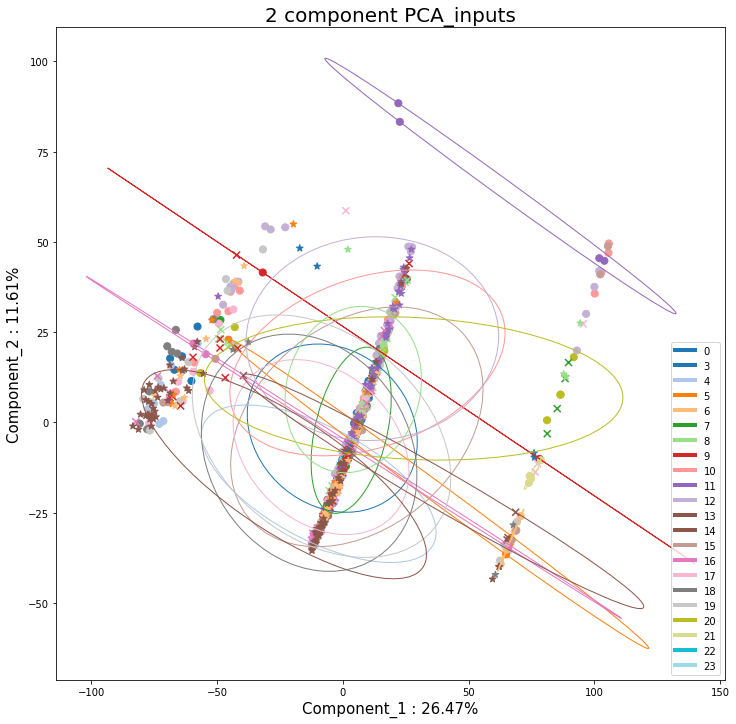

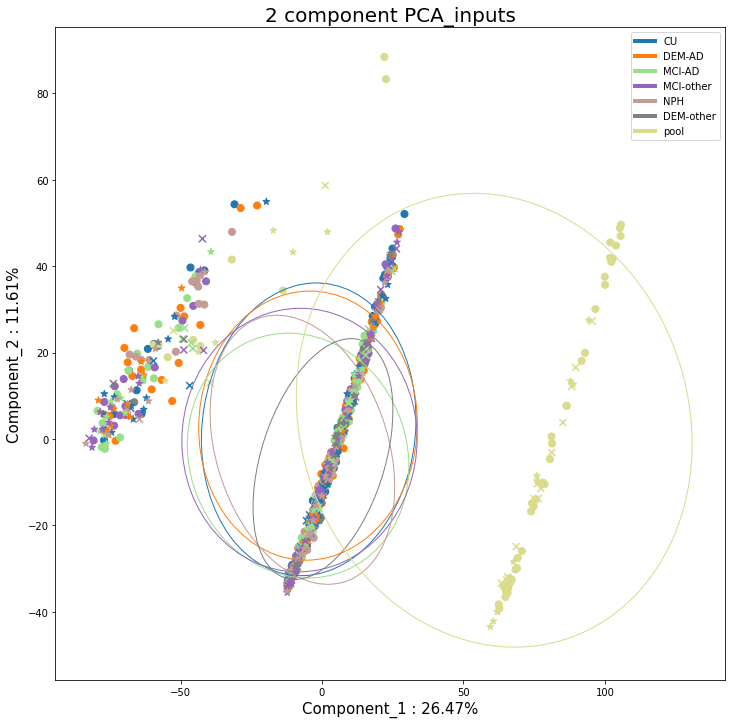

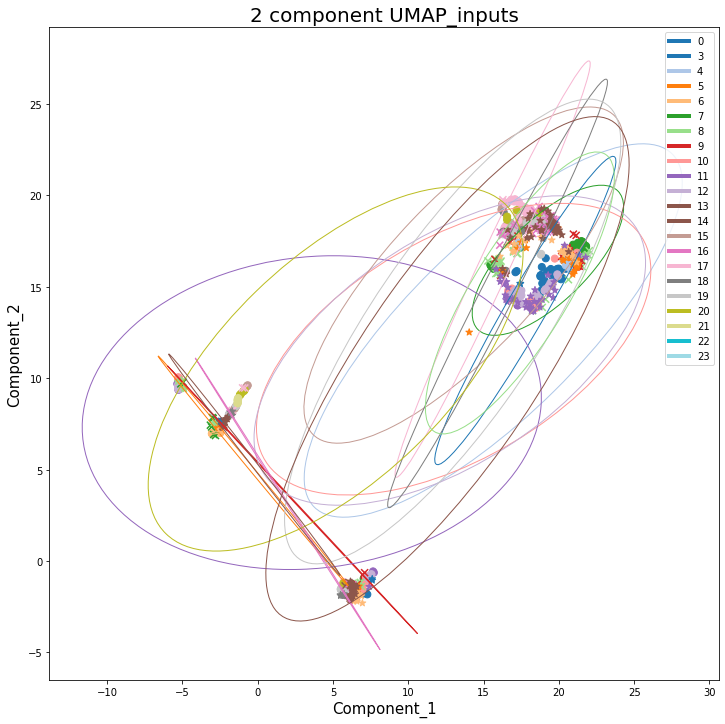

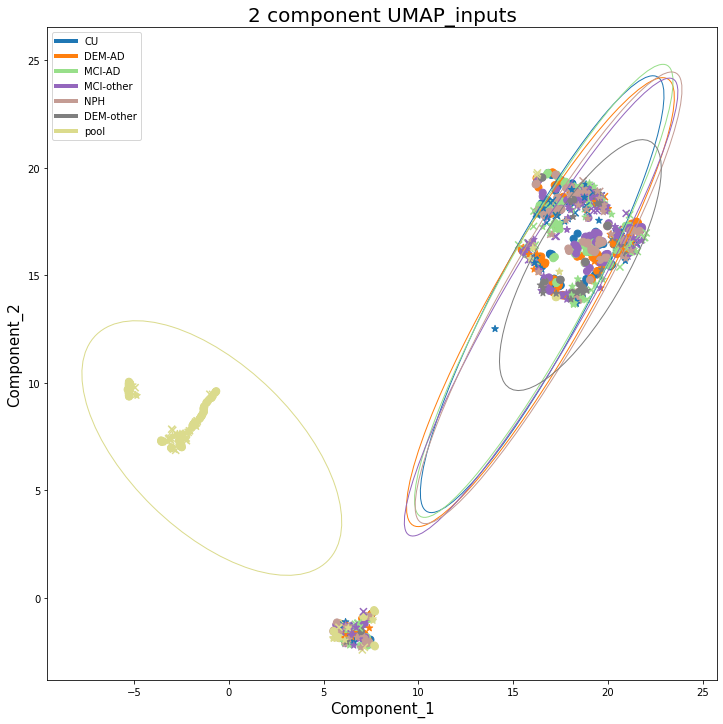

Iteration: 1
-1
valid_score: [0.23529411764705882, 0.2727272727272727, 0.24342105263157895, 0.27225130890052357, 0.21875] h_params: {'tol': 0.9744044165384433, 'max_iter': 933, 'penalty': 'l2', 'C': 9990.405154200935, 'class_weight': 'balanced'}
results/unique_genes/raw/linsvc/2
Iteration: 2
[0.23529411764705882, 0.2727272727272727, 0.24342105263157895, 0.27225130890052357, 0.21875]
valid_score: [0.27450980392156865, 0.28342245989304815, 0.2631578947368421, 0.2356020942408377, 0.25] h_params: {'tol': 0.0038576507737700483, 'max_iter': 389, 'penalty': 'l2', 'C': 9355.39077252125, 'class_weight': 'balanced'}
results/unique_genes/raw/linsvc/2
Iteration: 3
[0.27450980392156865, 0.28342245989304815, 0.2631578947368421, 0.2356020942408377, 0.25]
valid_score: [0.22875816993464052, 0.25668449197860965, 0.26973684210526316, 0.25654450261780104, 0.2864583333333333] h_params: {'tol': 0.0017909937393907646, 'max_iter': 525, 'penalty': 'l2', 'C': 2295.7729077210424, 'class_weight': 'balanced'}
Iter

In [30]:
metrics = log_fct(copy.deepcopy(data), unique_labels, unique_batches, metrics)
train_fct(copy.deepcopy(data), n_meta, train_models)



In [31]:
if log_stuff:
    # table = pd.DataFrame(columns=list(metrics['raw']['all'].keys()) + ['delta', 'delta_pool'], index=list(metrics.keys()))
    cols = ['qc_aPCC', '[qc_dist/tot_eucl]', 'lisi', 'silhouette', 'kbet', 'shannon', 'adjusted_rand_score', 'adjusted_mutual_info_score']
    cols_pool = ['pool lisi', 'pool silhouette', 'pool kbet', 'pool shannon', 'pool adjusted_rand_score', 'pool adjusted_mutual_info_score',]
    table = pd.DataFrame(columns=cols + cols_pool, index=list(metrics.keys()))
    # table = table.drop(['qc_dist', 'b_euclidean', 'euclidean', "[b_euclidean/tot_eucl]"], 1)
    for col in cols:
        for row in list(table.index):
            # if 'delta' in col:
            #     table[col][row] = metrics[row][col]
            # else:
            try:
                if isinstance(metrics[row]['all'][col], dict):
                    table[col][row] = metrics[row]['all'][col]["domains"]
                    try:
                        table[f'pool {col}'][row] = metrics[row]['all_pool'][col]["domains"]
                    except:
                        pass
                    # table[col][row]["domains"] = metrics[row]['all'][col]["domains"]
                    # table[col][row]["labels"] = metrics[row]['all'][col]["labels"]
                else:
                    try:
                        table[col][row] = metrics[row]['valid'][col]
                    except:
                        table[col][row] = metrics[row]['all'][col]

            except:
                try:
                    table[col][row] = metrics[row]['all_pool'][col]
                except:
                    table[col][row] = metrics[row]['valid'][col]

    table

# meta only

# Minmax

In [ ]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('minmax', data, device='cpu')

In [ ]:
metrics = log_fct(copy.deepcopy(data), unique_labels, unique_batches, metrics)
train_fct(copy.deepcopy(data), n_meta, train_models)


# Minmax per batch

In [ ]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('minmax_per_batch', data, device='cpu')

In [ ]:
metrics = log_fct(copy.deepcopy(data), unique_labels, unique_batches, metrics)
train_fct(copy.deepcopy(data), n_meta, train_models)


# Standard

In [ ]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

In [ ]:
metrics = log_fct(copy.deepcopy(data), unique_labels, unique_batches, metrics)
train_fct(copy.deepcopy(data), n_meta, train_models)


# Standard per batch

In [ ]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard_per_batch', data, device='cpu')

In [ ]:
metrics = log_fct(copy.deepcopy(data), unique_labels, unique_batches, metrics)
train_fct(copy.deepcopy(data), n_meta, train_models)


# Robust

In [ ]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('robust', data, device='cpu')

In [ ]:
metrics = log_fct(copy.deepcopy(data), unique_labels, unique_batches, metrics)
train_fct(copy.deepcopy(data), n_meta, train_models)


# Robust per batch

In [ ]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('robust_per_batch', data, device='cpu')

In [ ]:
metrics = log_fct(copy.deepcopy(data), unique_labels, unique_batches, metrics)
train_fct(copy.deepcopy(data), n_meta, train_models)


# Combat

In [ ]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data = remove_batch_effect(get_berm('combat'), data)

# data['inputs']['all'] = data['inputs']['all'].fillna(0)
#data['inputs']['train'][np.isnan(data['inputs']['train'])] = 0
# data['inputs']['train_pool'][np.isnan(data['inputs']['train_pool'])] = 0
# data['inputs']['valid'][np.isnan(data['inputs']['valid'])] = 0
# data['inputs']['valid_pool'][np.isnan(data['inputs']['valid_pool'])] = 0
# data['inputs']['test'][np.isnan(data['inputs']['test'])] = 0
# data['inputs']['test_pool'][np.isnan(data['inputs']['test_pool'])] = 0


In [ ]:
metrics = log_fct(copy.deepcopy(data), unique_labels, unique_batches, metrics)
train_fct(copy.deepcopy(data), n_meta, train_models)


# pyCombat

In [ ]:
from combat.pycombat import pycombat
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data = use_pycombat(pycombat, data)


In [ ]:
metrics = log_fct(copy.deepcopy(data), unique_labels, unique_batches, metrics)
train_fct(copy.deepcopy(data), n_meta, train_models)


# Harmony

In [ ]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)
data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data['inputs']['all'].iloc[:] = minmax_scaler.fit_transform(data['inputs']['all'])
data['inputs']['all_pool'].iloc[:] = minmax_scaler.transform(data['inputs']['all_pool'])
data['inputs']['train'].iloc[:] = minmax_scaler.transform(data['inputs']['train'])
data['inputs']['train_pool'].iloc[:] = minmax_scaler.transform(data['inputs']['train_pool'])
data['inputs']['valid'].iloc[:] = minmax_scaler.transform(data['inputs']['valid'])
data['inputs']['valid_pool'].iloc[:] = minmax_scaler.transform(data['inputs']['valid_pool'])
data['inputs']['test'].iloc[:] = minmax_scaler.transform(data['inputs']['test'])
data['inputs']['test_pool'].iloc[:] = minmax_scaler.transform(data['inputs']['test_pool'])
data = remove_batch_effect(get_berm('harmony'), data)



In [ ]:
metrics = log_fct(copy.deepcopy(data), unique_labels, unique_batches, metrics)
train_fct(copy.deepcopy(data), n_meta, train_models)


# WaveICA

In [ ]:
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

def waveicaR(data, batches):
    with localconverter(robjects.default_converter + pandas2ri.converter):
        data_r = robjects.conversion.py2rpy(data)

    # data_r = robjects.r.matrix(robjects.FloatVector(df.values.reshape(-1)), nrow=df.shape[0])
    batches_r = robjects.IntVector(batches.reshape(-1))
    waveica = importr('WaveICA')
    # data_r.colnames = robjects.StrVector([str(x) for x in range(df.shape[1])])
    newdata = waveica.WaveICA(dat=data_r, batch=batches_r)
    with localconverter(robjects.default_converter + pandas2ri.converter):
        newdata = { key : np.array(robjects.conversion.rpy2py(newdata.rx2(key))) for key in newdata.names }
    return newdata['data_wave']


path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)
data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

df = data['inputs']['all']
all_batches = data['batches']['all']
# assert np.sum(all_batches != np.concatenate((data['batches']['train'], data['batches']['valid'], data['batches']['test']))) == 0
tmp = waveicaR(df, all_batches)

In [ ]:
previous_len = 0
for g in list(data['inputs'].keys())[1:-1]:
    data['inputs'][g] = pd.DataFrame(
        tmp[previous_len:previous_len + data['inputs'][g].shape[0]],
        index=data['inputs'][g].index)
    previous_len += data['inputs'][g].shape[0]
try:
    data['inputs']['all'] = pd.DataFrame(tmp, index=df.index, columns=df.columns)
except:
    data['inputs']['all'] = pd.DataFrame(tmp, index=df.index)

if n_meta == 2:
    for group in data['inputs']:
        data['inputs'][group] = pd.DataFrame(np.concatenate((data['inputs'][group], data['meta'][group]), 1))


In [ ]:
metrics = log_fct(copy.deepcopy(data), unique_labels, unique_batches, metrics)
train_fct(copy.deepcopy(data), n_meta, train_models)


In [ ]:
if log_stuff:
    # table = pd.DataFrame(columns=list(metrics['raw']['all'].keys()) + ['delta', 'delta_pool'], index=list(metrics.keys()))
    cols = ['qc_aPCC', '[qc_dist/tot_eucl]', 'lisi', 'silhouette', 'kbet', 'shannon', 'adjusted_rand_score', 'adjusted_mutual_info_score']
    cols_pool = ['pool lisi', 'pool silhouette', 'pool kbet', 'pool shannon', 'pool adjusted_rand_score', 'pool adjusted_mutual_info_score',]
    table = pd.DataFrame(columns=cols + cols_pool, index=list(metrics.keys()))
    # table = table.drop(['qc_dist', 'b_euclidean', 'euclidean', "[b_euclidean/tot_eucl]"], 1)
    for col in cols:
        for row in list(table.index):
            # if 'delta' in col:
            #     table[col][row] = metrics[row][col]
            # else:
            try:
                if isinstance(metrics[row]['all'][col], dict):
                    table[col][row] = metrics[row]['all'][col]["domains"]
                    try:
                        table[f'pool {col}'][row] = metrics[row]['all_pool'][col]["domains"]
                    except:
                        pass
                    # table[col][row]["domains"] = metrics[row]['all'][col]["domains"]
                    # table[col][row]["labels"] = metrics[row]['all'][col]["labels"]
                else:
                    try:
                        table[col][row] = metrics[row]['valid'][col]
                    except:
                        table[col][row] = metrics[row]['all'][col]

            except:
                try:
                    table[col][row] = metrics[row]['all_pool'][col]
                except:
                    table[col][row] = metrics[row]['valid'][col]

table

# AE 

In [ ]:
from src.dl.models.pytorch.aedann import AutoEncoder2 as AutoEncoder


## Encoded

In [ ]:
data['inputs']['all'].shape

(921, 896)

In [ ]:
path = 'data/Alzheimer'
data, unique_labels, unique_batches = get_alzheimer(path, args)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('robust', data, device='cpu')

if not best_correction:
    # Best score run Brain-1446
    path='logs/best_models_server/ae_then_classifier_holdout/no_vae0/model_1.pth'
else:
    # Run Brain-
    path='logs/ae_classifier_holdout/.../model_3.pth'
    
# best score is autoencoder0, best correction autoencoder3
if not best_correction:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                     n_batches=22,
                     nb_classes=2,
                     layer1=1692,
                     mapper=0,
                     layer2=183,
                     dropout=0,
                           n_meta=0,
                           n_emb=2,
                           n_layers=2,
                     variational=0, conditional=False, zinb=0,
                     add_noise=0, tied_weights=0, 
                     use_gnn=0, device='cpu').to('cpu')
else:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                 n_batches=21,
                 nb_classes=2,
                 layer1=595,
                 mapper=0,
                 layer2=266,
                 dropout=0,
                 variational=0, conditional=False, zinb=0,
                 add_noise=0, tied_weights=0, n_meta=2,
                 use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}'))
best_ae2.eval()
pass

NameError: name 'AutoEncoder' is not defined

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False, mapping=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False, mapping=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False, mapping=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False, mapping=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'ae-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'ae-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'ae-enc')


In [ ]:
%matplotlib inline
log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)
log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)


In [ ]:
for group in enc_data['inputs']:
    if n_meta == 2:
        enc_data['inputs'][group] = pd.DataFrame(np.concatenate((enc_data['inputs'][group].values, enc_data['meta'][group]), 1))


In [ ]:
if train_models:
    train_rfc(enc_data, 'ae-enc', n_meta)
    train_linsvc(enc_data, 'ae-enc', n_meta)
    # train_logreg(enc_data, 'ae-enc', n_meta)
    

# NORMAE 

In [ ]:
from src.dl.models.pytorch.aedann import AutoEncoder2 as AutoEncoder


## Encoded

In [ ]:
path = 'data'
data, unique_labels, unique_batches = get_alzheimer(path, csv_name, bad_batches, remove_zeros=0)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

if not best_correction:
    # Best score run Brain-1446
    path='logs/best_models_server/ae_then_classifier_holdout/unique_genes/normae_vae0/model_1.pth'
else:
    # Run Brain-
    path='logs/ae_classifier_holdout/.../model_3.pth'
    
# best score is autoencoder0, best correction autoencoder3
if not best_correction:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                     n_batches=22,
                     nb_classes=2,
                     layer1=1184,
                     mapper=0,
                     layer2=339,
                     dropout=0,
                           n_meta=0,
                           n_emb=2,
                           n_layers=2,
                     variational=0, conditional=False, zinb=0,
                     add_noise=0, tied_weights=0, 
                     use_gnn=0, device='cpu').to('cpu')
else:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                 n_batches=21,
                 nb_classes=2,
                 layer1=595,
                 mapper=0,
                 layer2=266,
                 dropout=0,
                 variational=0, conditional=False, zinb=0,
                 add_noise=0, tied_weights=0, n_meta=2,
                 use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=True)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=True)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=True)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'normae-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'normae-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'ae-enc')


In [ ]:
%matplotlib inline
log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)
log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)


In [ ]:
for group in enc_data['inputs']:
    if n_meta == 2:
        enc_data['inputs'][group] = pd.DataFrame(np.concatenate((enc_data['inputs'][group].values, enc_data['meta'][group]), 1))


In [ ]:
if train_models:
    train_rfc(enc_data, 'ae-enc', n_meta)
    train_linsvc(enc_data, 'ae-enc', n_meta)
    # train_logreg(enc_data, 'ae-enc', n_meta)
    

# AEDANN

## Encoded

In [ ]:
path = 'data/Alzheimer'
args.remove_zeros=0
data, unique_labels, unique_batches = get_alzheimer(path, args)
print(data['inputs']['train'].shape)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('robust', data, device='cpu')

if not best_correction:
    # Best score run Brain-1446
    path='logs/best_models_server/ae_then_classifier_holdout/DANN_vae0/model_1.pth'
else:
    # Run Brain-
    path='logs/ae_classifier_holdout/.../model_3.pth'
    
# best score is autoencoder0, best correction autoencoder3
if not best_correction:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                     n_batches=22,
                     nb_classes=2,
                     layer1=666,
                     mapper=0,
                     layer2=748,
                     dropout=0,
                           n_meta=0,
                           n_emb=2,
                           n_layers=2,
                     variational=0, conditional=False, zinb=0,
                     add_noise=0, tied_weights=0, 
                     use_gnn=0, device='cpu').to('cpu')
else:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                 n_batches=21,
                 nb_classes=2,
                 layer1=595,
                 mapper=0,
                 layer2=266,
                 dropout=0,
                 variational=0, conditional=False, zinb=0,
                 add_noise=0, tied_weights=0, n_meta=2,
                 use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

(577, 896)


RuntimeError: Error(s) in loading state_dict for AutoEncoder2:
	size mismatch for enc.linear1.0.weight: copying a param with shape torch.Size([666, 887]) from checkpoint, the shape in current model is torch.Size([666, 896]).
	size mismatch for dec.linear2.0.weight: copying a param with shape torch.Size([887, 666]) from checkpoint, the shape in current model is torch.Size([896, 666]).
	size mismatch for dec.linear2.0.bias: copying a param with shape torch.Size([887]) from checkpoint, the shape in current model is torch.Size([896]).
	size mismatch for _dec_mean.0.weight: copying a param with shape torch.Size([887, 666]) from checkpoint, the shape in current model is torch.Size([896, 666]).
	size mismatch for _dec_mean.0.bias: copying a param with shape torch.Size([887]) from checkpoint, the shape in current model is torch.Size([896]).
	size mismatch for _dec_disp.0.weight: copying a param with shape torch.Size([887, 666]) from checkpoint, the shape in current model is torch.Size([896, 666]).
	size mismatch for _dec_disp.0.bias: copying a param with shape torch.Size([887]) from checkpoint, the shape in current model is torch.Size([896]).
	size mismatch for _dec_pi.0.weight: copying a param with shape torch.Size([887, 666]) from checkpoint, the shape in current model is torch.Size([896, 666]).
	size mismatch for _dec_pi.0.bias: copying a param with shape torch.Size([887]) from checkpoint, the shape in current model is torch.Size([896]).

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=True, mapping=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=True, mapping=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())


In [ ]:
enc_data['inputs']['train']

In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'aedann-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'aedann-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'aedann-enc')
    

In [ ]:
%matplotlib inline
log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)
log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)


In [ ]:
for group in enc_data['inputs']:
    if n_meta == 2:
        enc_data['inputs'][group] = pd.DataFrame(np.concatenate((enc_data['inputs'][group].values, enc_data['meta'][group]), 1))


In [ ]:
if train_models:
    train_rfc(enc_data, 'aedann-enc', n_meta)
    train_linsvc(enc_data, 'aedann-enc', n_meta)
    # train_logreg(enc_data, 'aedann-enc', n_meta)
    

# AE-invTriplet

## Encoded

In [ ]:
path = 'data'
data, unique_labels, unique_batches = get_alzheimer(path, csv_name, bad_batches, remove_zeros=0)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

if not best_correction:
    # Best score run Brain-1446
    path='logs/best_models_server/ae_then_classifier_holdout/unique_genes/inverseTriplet_vae0/model_1.pth'
else:
    # Run Brain-
    path='logs/ae_classifier_holdout/.../model_3.pth'
    
# best score is autoencoder0, best correction autoencoder3
if not best_correction:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                     n_batches=22,
                     nb_classes=2,
                     layer1=1543,
                     mapper=0,
                     layer2=514,
                     dropout=0,
                           n_meta=0,
                           n_emb=2,
                           n_layers=2,
                     variational=0, conditional=False, zinb=0,
                     add_noise=0, tied_weights=0, 
                     use_gnn=0, device='cpu').to('cpu')
else:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                 n_batches=21,
                 nb_classes=2,
                 layer1=595,
                 mapper=0,
                 layer2=266,
                 dropout=0,
                 variational=0, conditional=False, zinb=0,
                 add_noise=0, tied_weights=0, n_meta=2,
                 use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=True)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=True)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=True)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=True)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=True)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=True)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=True)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'ae-invTriplet-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'ae-invTriplet-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'aedann-enc')
    

In [ ]:
%matplotlib inline
log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)
log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)


In [ ]:
for group in enc_data['inputs']:
    if n_meta == 2:
        enc_data['inputs'][group] = pd.DataFrame(np.concatenate((enc_data['inputs'][group].values, enc_data['meta'][group]), 1))


In [ ]:
if train_models:
    train_rfc(enc_data, 'ae-invTriplet-enc', n_meta)
    train_linsvc(enc_data, 'ae-invTriplet-enc', n_meta)
    # train_logreg(enc_data, 'aedann-enc', n_meta)
    

# AE-revTriplet

## Encoded

In [ ]:
path = 'data'
data, unique_labels, unique_batches = get_alzheimer(path, csv_name, bad_batches, remove_zeros=0)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

if not best_correction:
    # Best score run Brain-1446
    path='logs/best_models_server/ae_then_classifier_holdout/unique_genes/revTriplet_vae0/model_1.pth'
else:
    # Run Brain-
    path='logs/ae_classifier_holdout/.../model_3.pth'
    
# best score is autoencoder0, best correction autoencoder3
if not best_correction:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                     n_batches=22,
                     nb_classes=2,
                     layer1=1365,
                     mapper=0,
                     layer2=493,
                     dropout=0,
                           n_meta=0,
                           n_emb=2,
                           n_layers=2,
                     variational=0, conditional=False, zinb=0,
                     add_noise=0, tied_weights=0, 
                     use_gnn=0, device='cpu').to('cpu')
else:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                 n_batches=21,
                 nb_classes=2,
                 layer1=595,
                 mapper=0,
                 layer2=266,
                 dropout=0,
                 variational=0, conditional=False, zinb=0,
                 add_noise=0, tied_weights=0, n_meta=2,
                 use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=True)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=True)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=True)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=True)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'ae-revTriplet-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'ae-revTriplet-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'aedann-enc')
    

In [ ]:
for group in enc_data['inputs']:
    if n_meta == 2:
        enc_data['inputs'][group] = pd.DataFrame(np.concatenate((enc_data['inputs'][group], enc_data['meta'][group]), 1))


In [ ]:
%matplotlib inline
log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)
log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)


In [ ]:
if train_models:
    train_rfc(enc_data, 'ae-revTriplet-enc', n_meta)
    train_linsvc(enc_data, 'ae-revTriplet-enc', n_meta)
    # train_logreg(enc_data, 'aedann-enc', n_meta)
    

# NORMVAE

## Encoded

In [ ]:
path = 'data'
data, unique_labels, unique_batches = get_alzheimer(path, csv_name, bad_batches, remove_zeros=0)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

if not best_correction:
    # Best score run Brain-1446
    path='logs/best_models_server/ae_then_classifier_holdout/unique_genes/normae_vae1/model_1.pth'
else:
    # Run Brain-
    path='logs/ae_classifier_holdout/.../model_3.pth'
    
# best score is autoencoder0, best correction autoencoder3
if not best_correction:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                     n_batches=22,
                     nb_classes=2,
                     layer1=1181,
                     mapper=0,
                     layer2=433,
                     dropout=0,
                           n_meta=0,
                           n_emb=2,
                           n_layers=2,
                     variational=1, conditional=False, zinb=0,
                     add_noise=0, tied_weights=0, 
                     use_gnn=0, device='cpu').to('cpu')
else:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                 n_batches=21,
                 nb_classes=2,
                 layer1=595,
                 mapper=0,
                 layer2=266,
                 dropout=0,
                 variational=0, conditional=False, zinb=0,
                 add_noise=0, tied_weights=0, n_meta=2,
                 use_gnn=0, device='cpu').to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'normvae-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'normvae-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'vae-enc')


In [ ]:
%matplotlib inline
log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)
log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)


In [ ]:
for group in enc_data['inputs']:
    if n_meta == 2:
        enc_data['inputs'][group] = pd.DataFrame(np.concatenate((enc_data['inputs'][group], enc_data['meta'][group]), 1))


In [ ]:
if train_models:
    train_rfc(enc_data, 'vae-enc', n_meta)
    train_linsvc(enc_data, 'vae-enc', n_meta)
    # train_logreg(enc_data, 'vae-enc', n_meta)
    

# VAE

## Encoded

In [ ]:
path = 'data'
data, unique_labels, unique_batches = get_alzheimer(path, csv_name, bad_batches, remove_zeros=0)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

if not best_correction:
    # Best score run Brain-1446
    path='logs/best_models_server/ae_then_classifier_holdout/unique_genes/no_vae1/model_1.pth'
else:
    # Run Brain-
    path='logs/ae_classifier_holdout/.../model_3.pth'
    
# best score is autoencoder0, best correction autoencoder3
if not best_correction:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                     n_batches=22,
                     nb_classes=2,
                     layer1=1629,
                     mapper=0,
                     layer2=136,
                     dropout=0,
                           n_meta=0,
                           n_emb=2,
                           n_layers=2,
                     variational=1, conditional=False, zinb=0,
                     add_noise=0, tied_weights=0, 
                     use_gnn=0, device='cpu').to('cpu')
else:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                 n_batches=21,
                 nb_classes=2,
                 layer1=595,
                 mapper=0,
                 layer2=266,
                 dropout=0,
                 variational=0, conditional=False, zinb=0,
                 add_noise=0, tied_weights=0, n_meta=2,
                 use_gnn=0, device='cpu').to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'vae-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'vae-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'vae-enc')


In [ ]:
%matplotlib inline
log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)
log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)


In [ ]:
for group in enc_data['inputs']:
    if n_meta == 2:
        enc_data['inputs'][group] = pd.DataFrame(np.concatenate((enc_data['inputs'][group], enc_data['meta'][group]), 1))


In [ ]:
if train_models:
    train_rfc(enc_data, 'vae-enc', n_meta)
    train_linsvc(enc_data, 'vae-enc', n_meta)
    # train_logreg(enc_data, 'vae-enc', n_meta)
    

# VAEDANN

## Encoded

In [ ]:
path = 'data'
data, unique_labels, unique_batches = get_alzheimer('data/Alzheimer', csv_name, bad_batches, remove_zeros=0)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

if not best_correction:
    # Best score run Brain-1446
    path='logs/best_models_server/ae_then_classifier_holdout/unique_genes/DANN_vae1/model_1.pth'
else:
    # Run Brain-
    path='logs/ae_classifier_holdout/.../model_3.pth'
    
# best score is autoencoder0, best correction autoencoder3
if not best_correction:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                     n_batches=22,
                     nb_classes=2,
                     layer1=941,
                     mapper=0,
                     layer2=265,
                     dropout=0,
                           n_meta=0,
                           n_emb=2,
                           n_layers=2,
                     variational=1, conditional=False, zinb=0,
                     add_noise=0, tied_weights=0, 
                     use_gnn=0, device='cpu').to('cpu')
else:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                 n_batches=21,
                 nb_classes=2,
                 layer1=595,
                 mapper=0,
                 layer2=266,
                 dropout=0,
                 variational=0, conditional=False, zinb=0,
                 add_noise=0, tied_weights=0, n_meta=2,
                 use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'vaedann-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'vaedann-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'aedann-enc')
    

In [ ]:
%matplotlib inline
log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)
log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)


In [ ]:
for group in enc_data['inputs']:
    if n_meta == 2:
        enc_data['inputs'][group] = pd.DataFrame(np.concatenate((enc_data['inputs'][group].values, enc_data['meta'][group]), 1))


In [ ]:
if train_models:
    train_rfc(enc_data, 'vaedann-enc', n_meta)
    train_linsvc(enc_data, 'vaedann-enc', n_meta)
    # train_logreg(enc_data, 'aedann-enc', n_meta)
    

# VAE-invTriplet

## Encoded

In [ ]:
path = 'data'
data, unique_labels, unique_batches = get_alzheimer(path, csv_name, bad_batches, remove_zeros=0)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

if not best_correction:
    # Best score run Brain-1446
    path='logs/best_models_server/ae_then_classifier_holdout/unique_genes/inverseTriplet_vae1/model_1.pth'
else:
    # Run Brain-
    path='logs/ae_classifier_holdout/.../model_3.pth'
    
# best score is autoencoder0, best correction autoencoder3
if not best_correction:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                     n_batches=22,
                     nb_classes=2,
                     layer1=1930,
                     mapper=0,
                     layer2=372,
                     dropout=0,
                           n_meta=0,
                           n_emb=2,
                           n_layers=2,
                     variational=1, conditional=False, zinb=0,
                     add_noise=0, tied_weights=0, 
                     use_gnn=0, device='cpu').to('cpu')
else:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                 n_batches=21,
                 nb_classes=2,
                 layer1=595,
                 mapper=0,
                 layer2=266,
                 dropout=0,
                 variational=0, conditional=False, zinb=0,
                 add_noise=0, tied_weights=0, n_meta=2,
                 use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'vae-invTriplet-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'vae-invTriplet-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'aedann-enc')
    

In [ ]:
%matplotlib inline
log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)
log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)


In [ ]:
for group in enc_data['inputs']:
    if n_meta == 2:
        enc_data['inputs'][group] = pd.DataFrame(np.concatenate((enc_data['inputs'][group].values, enc_data['meta'][group]), 1))


In [ ]:
if train_models:
    train_rfc(enc_data, 'vae-invTriplet-enc', n_meta)
    train_linsvc(enc_data, 'vae-invTriplet-enc', n_meta)
    # train_logreg(enc_data, 'aedann-enc', n_meta)
    

# VAE-revTriplet

## Encoded

In [ ]:
path = 'data'
data, unique_labels, unique_batches = get_alzheimer(path, csv_name, bad_batches, remove_zeros=0)
# unique_labels = get_unique_labels(data['labels']['all'])
unique_batches = np.unique(data['batches']['all'])
unique_cats = np.unique(data['cats']['all'])
unique_ages = np.array(['50s', '60s', '70s', '80+'])
unique_genders = np.unique(data['meta']['all'].iloc[:, 1])
n_cats = len(unique_labels)
n_batches = len(unique_batches)
n_ages = len(unique_ages)
n_genders = len(unique_genders)

data['age'] = {}
data['gender'] = {}
meta_age = []
for age in data['meta']['all'].iloc[:, 0]:
    if age < 50:
        meta_age += ['pool']
    elif age < 60:
        meta_age += ['50s']
    elif age < 70:
        meta_age += ['60s']
    elif age < 80:
        meta_age += ['70s']
    else:
        meta_age += ['80+']
data['age']['all'] = np.array(meta_age)
data['gender']['all'] = data['meta']['all'].iloc[:, 1]

data, _ = scale_data('standard', data, device='cpu')

if not best_correction:
    # Best score run Brain-1446
    path='logs/best_models_server/ae_then_classifier_holdout/unique_genes/revTriplet_vae1/model_1.pth'
else:
    # Run Brain-
    path='logs/ae_classifier_holdout/.../model_3.pth'
    
# best score is autoencoder0, best correction autoencoder3
if not best_correction:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                     n_batches=22,
                     nb_classes=2,
                     layer1=561,
                     mapper=0,
                     layer2=893,
                     dropout=0,
                           n_meta=0,
                           n_emb=2,
                           n_layers=2,
                     variational=1, conditional=False, zinb=0,
                     add_noise=0, tied_weights=0, 
                     use_gnn=0, device='cpu').to('cpu')
else:
    best_ae2 = AutoEncoder(data['inputs']['all'].shape[1],
                 n_batches=21,
                 nb_classes=2,
                 layer1=595,
                 mapper=0,
                 layer2=266,
                 dropout=0,
                 variational=0, conditional=False, zinb=0,
                 add_noise=0, tied_weights=0, n_meta=2,
                 use_gnn=0, device='cpu').to('cpu')

best_ae2.mapper.to('cpu')
best_ae2.dec.to('cpu')

best_ae2.load_state_dict(torch.load(f'{path}', map_location='cpu'))
best_ae2.eval()
pass

In [ ]:
batches = torch.Tensor([np.argwhere(unique_batches == x)[0][0] for x in data['batches']['all']]).detach().cpu()
enc_data = data.copy()
enc_data['inputs']['all'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all'].values), batches, sampling=False)
enc_data['inputs']['all_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['all_pool'].values), batches, sampling=False)
enc_data['inputs']['train'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train'].values), batches, sampling=False)
enc_data['inputs']['train_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['train_pool'].values), batches, sampling=False)
enc_data['inputs']['valid'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid'].values), batches, sampling=False)
enc_data['inputs']['valid_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['valid_pool'].values), batches, sampling=False)
enc_data['inputs']['test'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test'].values), batches, sampling=False)
enc_data['inputs']['test_pool'], _, _, _ = best_ae2.cpu()(torch.Tensor(data['inputs']['test_pool'].values), batches, sampling=False)

for group in enc_data['inputs']:
    enc_data['inputs'][group] = pd.DataFrame(enc_data['inputs'][group].detach().cpu().numpy())


In [ ]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
print("Mann      pval min    n pvals < 0.05")
table = pd.DataFrame(columns=['pval', 'n'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.mannwhitneyu(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))

print('ttests')
table = pd.DataFrame(columns=['pval'])
i = 0
for i, label in enumerate(unique_labels[:-1]):
    for label2 in unique_labels[i+1:]:
        if label != label2 and label != 'pool' and label2 != 'pool':
            pvals = stats.ttest_ind(
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label).squeeze()], 
                enc_data['inputs']['all'].values[np.argwhere(data['labels']['all'] == label2).squeeze()]
            )
            tmp = multipletests(pvals[1], 0.05, 'fdr_bh')[1]
            table.loc[f'{label}_{label2}', 'pval'] = tmp.min()
            table.loc[f'{label}_{label2}', 'n'] = len([x for x in tmp if x < 0.05])
            i += 1
print(tabulate(table))


In [ ]:
if log_stuff:
    metrics = log_pool_metrics(enc_data['inputs'], enc_data['batches'], metrics, 'vae-revTriplet-enc')
    metrics = log_metrics(enc_data, unique_labels, enc_data['batches'], metrics, 'vae-revTriplet-enc', device='cuda')
    # metrics = log_LDA(LDA, enc_data, {'batches': unique_batches, 'labels': unique_labels}, 0, metrics, 'aedann-enc')
    

In [ ]:
%matplotlib inline
log_ORD({'model': PCA(n_components=2), 'name': f'PCA_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)
log_ORD({'model': UMAP(n_components=2), 'name': f'UMAP_encs_labels'}, enc_data, 
        {'batches': unique_batches, 'labels': unique_labels, 
         # 'age': unique_ages
        }, 0)


In [ ]:
for group in enc_data['inputs']:
    if n_meta == 2:
        enc_data['inputs'][group] = pd.DataFrame(np.concatenate((enc_data['inputs'][group].values, enc_data['meta'][group]), 1))


In [ ]:
if train_models:
    train_rfc(enc_data, 'vae-revTriplet-enc', n_meta)
    train_linsvc(enc_data, 'vae-revTriplet-enc', n_meta)
    # train_logreg(enc_data, 'aedann-enc', n_meta)
    

# Table

In [ ]:
if log_stuff:
    # table = pd.DataFrame(columns=list(metrics['raw']['all'].keys()) + ['delta', 'delta_pool'], index=list(metrics.keys()))
    cols = ['qc_aPCC', '[qc_dist/tot_eucl]', 'lisi', 'silhouette', 'kbet', 'shannon', 'adjusted_rand_score', 'adjusted_mutual_info_score']
    cols_pool = ['pool lisi', 'pool silhouette', 'pool kbet', 'pool shannon', 'pool adjusted_rand_score', 'pool adjusted_mutual_info_score',]
    table = pd.DataFrame(columns=cols + cols_pool, index=list(metrics.keys()))
    # table = table.drop(['qc_dist', 'b_euclidean', 'euclidean', "[b_euclidean/tot_eucl]"], 1)
    for col in cols:
        for row in list(table.index):
            # if 'delta' in col:
            #     table[col][row] = metrics[row][col]
            # else:
            try:
                if isinstance(metrics[row]['all'][col], dict):
                    table[col][row] = metrics[row]['all'][col]["domains"]
                    try:
                        table[f'pool {col}'][row] = metrics[row]['all_pool'][col]["domains"]
                    except:
                        pass
                    # table[col][row]["domains"] = metrics[row]['all'][col]["domains"]
                    # table[col][row]["labels"] = metrics[row]['all'][col]["labels"]
                else:
                    try:
                        table[col][row] = metrics[row]['valid'][col]
                    except:
                        table[col][row] = metrics[row]['all'][col]

            except:
                try:
                    table[col][row] = metrics[row]['all_pool'][col]
                except:
                    table[col][row] = metrics[row]['valid'][col]

table